In [1]:
using Distributions, StatsFuns, StatsBase, LogTopReg, Stan
import Lazy.@>, Lazy.@>>, Lazy.@as

In [212]:
σ_μ = 1.0;
σ = 0.25;
σ_β = 0.5;

n = 50
p = 2;
nd = repeat([20],inner=[n]);
K = 10;
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
β = randn(K,p)*σ_β;
X = randn(p,n);
θ = fill((1-0.9)/(K-1),K,K);
for i in 1:K θ[i,i] = 0.9; end
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + β*X[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> vcat( hcat(rand(Categorical(θ[:,j]),nk[j,i]),rand(Categorical(θ[:,K-j+1]),nk[j,i]))' ), 1:K)...);
end

In [213]:
sum(nk,2)

10×1 Array{Int64,2}:
 117
 163
  34
  73
  93
 120
 130
  35
  67
 168

In [214]:
using RCall
R"library(rstan)"
R"topetho <- stan_model('~/code/topetho/categorical_topetho.stan')";

Y = hcat(y...)';
@rput Y;
N = sum(nd);
@rput N;
@rput K;
R"dat <- list(n=N,K=K,B=2,Bs=rep(K,2),Y=Y,alpha=1)";

In [218]:
runs = 20;
ll = Vector{Float64}(runs);
r = Vector{Array{Float64,2}}(runs);
for i in 1:runs
    R"optout <- optimizing(topetho,dat,verbose=F)";
    ll[i] = rcopy(R"optout$value");
    r[i] = rcopy(R"optout$par[str_detect(names(optout$par),'^r\\[')] %>% matrix(nrow=K,ncol=N,byrow = T)")
end

STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 1354747906
initial log joint probability = -5304.08
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 646211440
initial log joint probability = -5418.48
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
STAN OPTIMIZATION COMMAND (LBFGS)
init = random
save_iterations = 1
init_alpha = 0.001
tol_obj = 1e-12
tol_grad = 1e-08
tol_param = 1e-08
tol_rel_obj = 10000
tol_rel_grad = 1e+07
history_size = 5
seed = 525117580
initial log joint probability = -5196.87
Error evaluating model lo

In [219]:
ll

20-element Array{Float64,1}:
 -3463.89
 -3386.83
 -3310.09
 -3268.85
 -3198.54
 -3108.55
 -3397.45
 -3108.51
 -3350.33
 -3247.56
 -3211.32
 -3227.0 
 -3562.81
 -3248.3 
 -3298.76
 -3344.44
 -3267.2 
 -3399.23
 -3300.82
 -3108.51

In [220]:
zflat = mapslices(x -> rand(Categorical(x)),r[indmax(ll)],1);
z = Vector{Vector{Int64}}(n);
guh = 1;
for i in 1:n 
    z[i] = zflat[guh:(guh+nd[i]-1)];
    guh += nd[i];
end

In [221]:
pss = VectorPosterior(CategoricalPosterior(K),2);
@time fit = topiclmm(y,X,pss,K,zinit=z,iter=500);
ns = 500;

 21.593421 seconds (356.37 M allocations: 6.696 GB, 5.63% gc time)


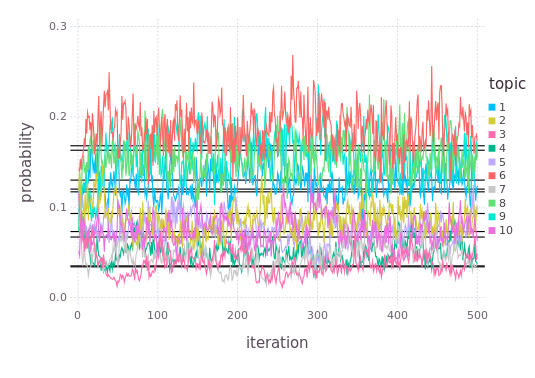

In [222]:
using Gadfly, DataFrames
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",yintercept=sum(nk,2)./sum(nk),
Geom.line,Geom.hline(color=colorant"black"))

In [223]:
warmup=200;
θpost1 = Int64[indmax(topicpd(fit[:topic][i,j][1]).alpha) for j=(warmup+1):ns, i=1:K];
ord = sortperm(vec(mean(θpost1,1)));
phat = @> mapslices(softmax,fit[:η][:,:,(warmup+1):ns],1) mean(3) getindex(ord,:);
pt = mapslices(softmax,η,1);
pdat = DataFrame(TrueProb=pt[:],EstProb=phat[:],RawProb=nk[:]./nd[1],topic=repeat(map(string,1:K),outer=[n]));

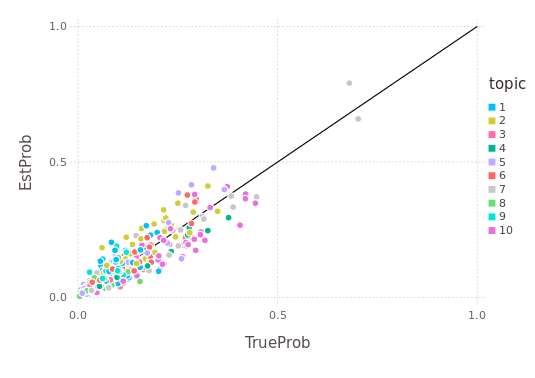

In [224]:
plot(layer(pdat,x="TrueProb",y="EstProb",color="topic",Geom.point),
layer(x=[0,1],y=[0,1],Theme(default_color=colorant"black"),Geom.line))

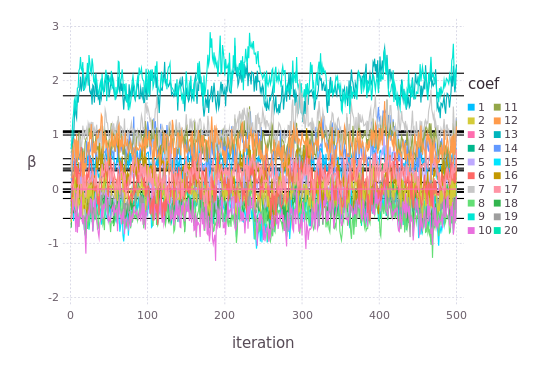

In [226]:
bdat = DataFrame(β = vec( refβ(fit[:β][:,ord,:],fit[:μ][ord,:]) ),
iteration = repeat(collect(1:ns),inner=[K*p]),coef = repeat(map(string,1:(K*p)),outer=[ns]))
plot(bdat,y="β",x="iteration",color="coef",yintercept=vec(refβ(β',μ)),Geom.line,Geom.hline(color=colorant"black"))

In [188]:
β

8×2 Array{Float64,2}:
  0.53428   -0.118685 
  0.291975  -0.474742 
  0.288577   0.428276 
 -0.224214  -0.0428445
  0.742982  -0.603393 
 -0.505947  -0.653656 
 -0.150224   0.255867 
  0.727956   0.0403227